In [2]:
import Bio.PDB
import numpy
import pandas as pd
import os
from Bio.PDB.Polypeptide import is_aa
from Bio.SeqUtils import seq1
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from collections import Counter

In [3]:
sns.set_context("talk")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
plt.rcParams.update({'font.size': 22})
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [5]:
def calc_residue_dist(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    try:
        atom_one = residue_one['CA']
        atom_two = residue_two['CA']
        diff_vector  = atom_one.coord - atom_two.coord
        return numpy.sqrt(numpy.sum(diff_vector * diff_vector))
    except:
        return calc_residue_dist_2(residue_one,residue_two)

def calc_residue_dist_2(residue_one, residue_two) :
    """Returns the closest distance between two residues"""
    min_distance = 100
    for atom_one in residue_one:
        if atom_one.name.startswith("H"):
            continue
        for atom_two in residue_two:
            if atom_two.name.startswith("H"):
                continue
            diff_vector  = atom_one.coord - atom_two.coord
            dist = numpy.sqrt(numpy.sum(diff_vector * diff_vector))
            if dist<min_distance:
                min_distance = dist
    return min_distance

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of C-alpha distances between two chains"""
    atoms_chain_one = [res for res in chain_one if is_aa(res)]
    atoms_chain_two =  [res for res in chain_two if is_aa(res)]
    answer = numpy.zeros((len(atoms_chain_one), len(atoms_chain_two)), numpy.float)
    #print(answer.shape)
    for row, residue_one in enumerate(atoms_chain_one) :
        for col, residue_two in enumerate(atoms_chain_two) :
            answer[row, col] = calc_residue_dist(residue_one, residue_two)
    return answer

In [7]:
all_data = []

for pdb_filename in tqdm_notebook(os.listdir("NR_H_Protein_Martin")):
    #pdb_filename = next(pdb_iter)
    if pdb_filename[-3:]!='pdb':
        continue
    pdb_code = pdb_filename.split(".")[0]
    #print(f'process {pdb_code}')
    structure = Bio.PDB.PDBParser().get_structure(pdb_code, "./NR_H_Protein_Martin/"+pdb_filename)
    model = structure[0]
    H_chain = model['H']
    H_numbering = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in H_chain if is_aa(res)]
    contact = np.zeros_like(H_numbering,dtype=bool)
    for c in model:
        if c.id == 'H':
            continue
        dist_matrix = calc_dist_matrix(c, H_chain)
        try:
            contact = contact | (dist_matrix.min(0) < 8)
        except Exception as e:
            print(pdb_filename)
            print(c)
            print(e)
            print("-----------")
    all_data.append([H_numbering,contact])



    #dist_matrix = calc_dist_matrix(model["A"], model["H"])
    #seq_chain_one = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in model['H'] if is_aa(res)]
    #print(seq_chain_one)
    #seq_chain_two = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in model['A'] if is_aa(res)]
    #contact_map = dist_matrix < 12

/Users/zhesang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


5JA9_1.pdb
<Chain id=A>
zero-size array to reduction operation minimum which has no identity
-----------
4TVS_1.pdb
<Chain id=a>
zero-size array to reduction operation minimum which has no identity
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 3747.
  PDBConstructionWarning)


5JA8_1.pdb
<Chain id=F>
zero-size array to reduction operation minimum which has no identity
-----------
2XT1_1.pdb
<Chain id=B>
zero-size array to reduction operation minimum which has no identity
-----------
6EQI_1.pdb
<Chain id=B>
zero-size array to reduction operation minimum which has no identity
-----------
6EQI_1.pdb
<Chain id=C>
zero-size array to reduction operation minimum which has no identity
-----------
6I6J_1.pdb
<Chain id=C>
zero-size array to reduction operation minimum which has no identity
-----------
6GCI_1.pdb
<Chain id=B>
zero-size array to reduction operation minimum which has no identity
-----------



In [8]:
def annotate(f):
    content = [i for i in open(f).read().splitlines() if i.startswith("REMARK")]
    molecue_id = None
    for l in content:
        if "CHAIN H" in l:
            molecue_id = l.split(" ")[-1]
            break
    for l in content:
        if f"SPECIES" in l:
            _mol = l.split(":")[1].strip()
            if _mol == molecue_id:
                if  "HOMO" in l and not "MUS" in l:
                    return "Human"
                else:
                    return "else"
    return None

human_ig_pdb = []

for i in os.listdir("NR_LH_Protein_Martin"):
    ret = annotate("NR_LH_Protein_Martin/"+i)
    if ret=="Human":
        human_ig_pdb.append(i)
        

In [11]:
all_data_hl = []

for pdb_filename in tqdm_notebook(human_ig_pdb):
    if pdb_filename[-3:]!='pdb':
        continue
    #pdb_filename = next(pdb_iter)
    pdb_code = pdb_filename.split(".")[0]
    #print(f'process {pdb_code}')
    structure = Bio.PDB.PDBParser().get_structure(pdb_code, "NR_LH_Protein_Martin/"+pdb_filename)
    model = structure[0]
    H_chain = model['H']
    H_numbering = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in H_chain if is_aa(res)]
    contact = np.zeros_like(H_numbering,dtype=bool)
    for c in model:
        if c.id == 'H' or c.id =='L':
            continue
        dist_matrix = calc_dist_matrix(c, H_chain)
        try:
            contact = contact | (dist_matrix.min(0) < 8)
        except:
            print(pdb_filename)
            print(c)
            print("-----------")
    all_data_hl.append([H_numbering,contact])


/Users/zhesang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1726.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1909.
  PDBConstructionWarning)


6NB3_1.pdb
<Chain id=B>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 1844.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 1852.
  PDBConstructionWarning)


4D9Q_1.pdb
<Chain id=D>
-----------
4D9Q_1.pdb
<Chain id=E>
-----------
3QNZ_1.pdb
<Chain id=A>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1925.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1968.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 1979.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1990.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 2012.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: 

5VIY_1.pdb
<Chain id=J>
-----------
5VIY_1.pdb
<Chain id=F>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1944.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1792.
  PDBConstructionWarning)


5ANM_2.pdb
<Chain id=E>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 5174.
  PDBConstructionWarning)


5VAG_1.pdb
<Chain id=B>
-----------
3QO0_1.pdb
<Chain id=A>
-----------
6B08_1.pdb
<Chain id=C>
-----------
6B0G_1.pdb
<Chain id=D>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 3692.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 1790.
  PDBConstructionWarning)


4Y5V_1.pdb
<Chain id=G>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 3875.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 3892.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 3911.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 3993.
  PDBConstructionWarning)


5ESV_1.pdb
<Chain id=E>
-----------
3SO3_1.pdb
<Chain id=B>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5018.
  PDBConstructionWarning)


6O3B_1.pdb
<Chain id=B>
-----------
6MHR_1.pdb
<Chain id=D>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 3710.
  PDBConstructionWarning)


6EYO_1.pdb
<Chain id=B>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1978.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 2020.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 2031.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 2042.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 2064.
  PDBConstructionWarning)


4Y5X_1.pdb
<Chain id=G>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1994.
  PDBConstructionWarning)


5UMN_1.pdb
<Chain id=C>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1904.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1809.
  PDBConstructionWarning)


5WK3_1.pdb
<Chain id=Q>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1905.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 1917.
  PDBConstructionWarning)


4KXZ_1.pdb
<Chain id=P>
-----------
5A3I_1.pdb
<Chain id=A>
-----------
3D85_1.pdb
<Chain id=B>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3336.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4504.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 3730.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 3747.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 3761.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: 

6AXK_1.pdb
<Chain id=A>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1896.
  PDBConstructionWarning)


6D0X_1.pdb
<Chain id=B>
-----------
4PY8_1.pdb
<Chain id=I>
-----------
4PY8_1.pdb
<Chain id=J>
-----------


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1856.
  PDBConstructionWarning)


5BK0_1.pdb
<Chain id=B>
-----------



In [12]:
all_data_hl_2 = []

for pdb_filename in tqdm_notebook(human_ig_pdb):
    if pdb_filename[-3:]!='pdb':
        continue
    #pdb_filename = next(pdb_iter)
    pdb_code = pdb_filename.split(".")[0]
    #print(f'process {pdb_code}')
    structure = Bio.PDB.PDBParser().get_structure(pdb_code, "NR_LH_Protein_Martin/"+pdb_filename)
    model = structure[0]
    H_chain = model['H']
    H_numbering = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in H_chain if is_aa(res)]
    contact = np.zeros_like(H_numbering,dtype=bool)
    for c in model:
        if c.id != 'L':
            continue
        dist_matrix = calc_dist_matrix(c, H_chain)
        try:
            contact = contact | (dist_matrix.min(0) < 8)
        except:
            print(pdb_filename)
            print(c)
            print("-----------")
    all_data_hl_2.append([H_numbering,contact])


/Users/zhesang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1726.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1909.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 1844.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 1852.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1925.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: 

In [13]:
def normalize_hit(data):
    count_position = []
    count_hit=[]
    for i in data:
        x,y = i
        count_position += x
        x = np.array(x)
        contacted_aa = x[np.argwhere(y==True).flatten()]
        count_hit += list(contacted_aa)

    aaa = dict(Counter(count_hit))
    bbb = dict(Counter(count_position))

    ccc = aaa.copy()
    for i in bbb.keys():
        if not str(i) in ccc.keys():
            ccc[str(i)] =0
        else:
            #ccc[str(i)] = ccc[str(i)]/bbb[str(i)]
            ccc[str(i)] = ccc[str(i)]/len(data)
    sorted_result = sorted([[pos,hits] for pos,hits in ccc.items()],key=lambda x: natural_keys(x[0]))
    return sorted_result

In [14]:
nb_result = normalize_hit(all_data)
hum_result = normalize_hit(all_data_hl)
hum_HL_result = normalize_hit(all_data_hl_2)

In [15]:
pos_nb = [i[0] for i in nb_result]
hit_nb = [i[1] for i in nb_result]
pos_hum = [i[0] for i in hum_result]
hit_hum = [i[1] for i in hum_result]
pos_HL__hum = [i[0] for i in hum_HL_result]
hit_HL_hum = [i[1] for i in hum_HL_result]

In [16]:
shared_keys = set(pos_nb)&set(pos_hum)

In [17]:
pos_nb_shared=[]
hit_nb_shared=[]
pos_hum_shared=[]
hit_hum_shared=[]
pos_HL_hum_shared=[]
hit_HL_hum_shared=[]

for _pos,_hit in zip(pos_nb,hit_nb):
    if _pos in shared_keys:
        pos_nb_shared.append(_pos)
        hit_nb_shared.append(_hit)
for _pos,_hit in zip(pos_hum,hit_hum):
    if _pos in shared_keys:
        pos_hum_shared.append(_pos)
        hit_hum_shared.append(_hit)
for _pos,_hit in zip(pos_HL__hum,hit_HL_hum):
    if _pos in shared_keys:
        pos_HL_hum_shared.append(_pos)
        hit_HL_hum_shared.append(_hit)

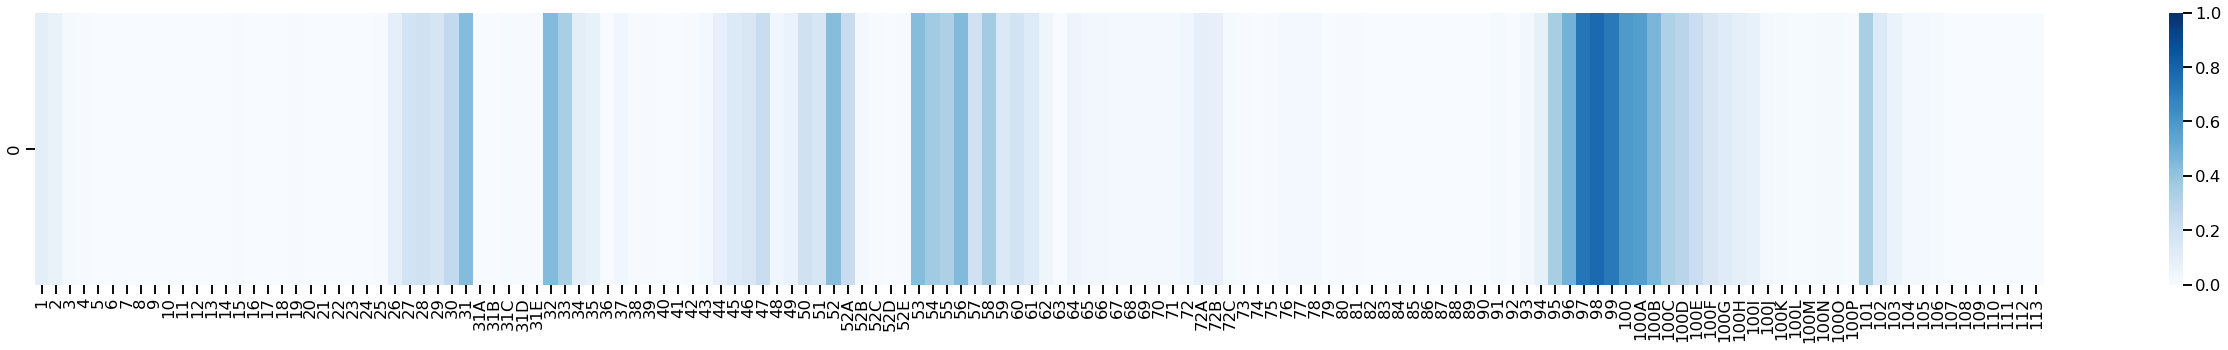

In [28]:
plt.figure(figsize=(45,5))
sns.heatmap(np.array(hit_nb_shared).reshape(1,-1),xticklabels=pos_nb_shared,cmap='Blues',vmin=0,vmax=1)
plt.savefig("Nb_contacts.svg",format='svg')

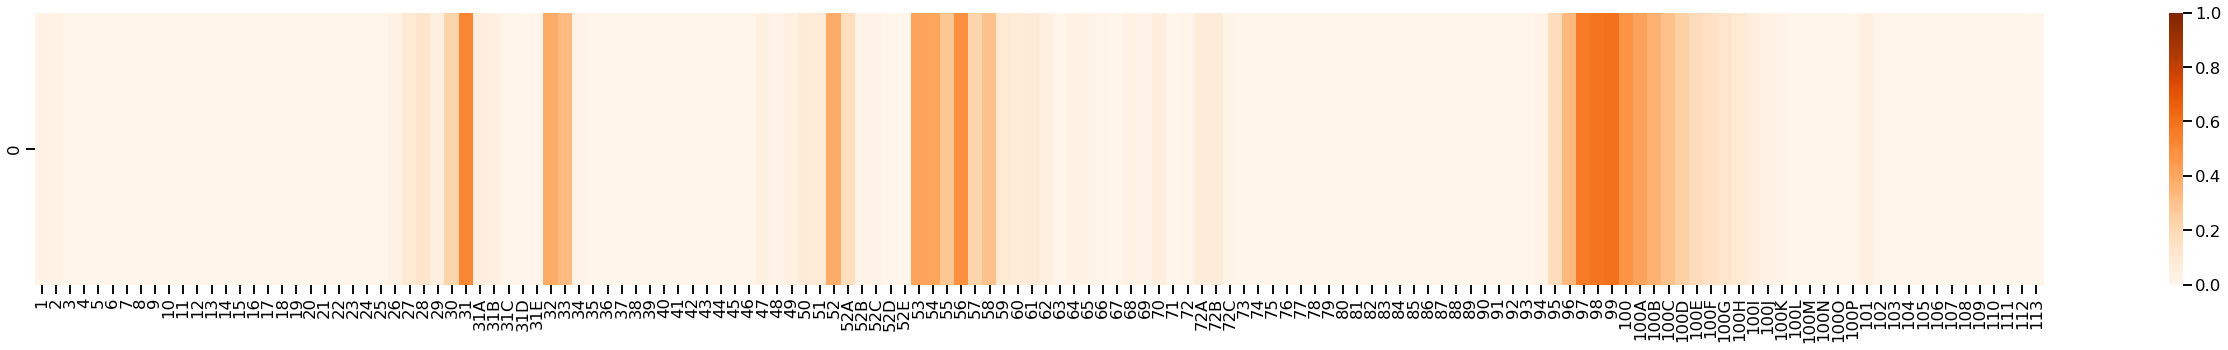

In [29]:
plt.figure(figsize=(45,5))
sns.heatmap(np.array(hit_hum_shared).reshape(1,-1),xticklabels=pos_hum_shared,cmap='Oranges',vmin=0,vmax=1)
plt.savefig("hum_contacts.svg",format='svg')

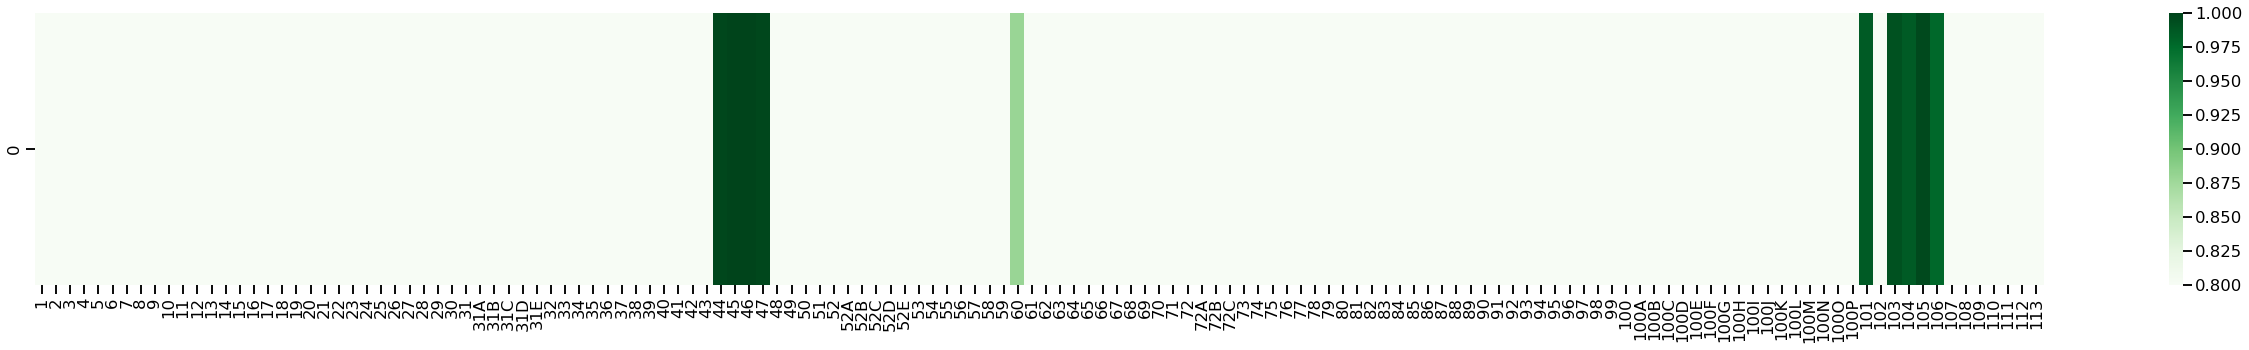

In [23]:
plt.figure(figsize=(45,5))
sns.heatmap(np.array(hit_HL_hum_shared).reshape(1,-1),xticklabels=pos_HL_hum_shared,cmap='Greens',vmin=0.8,vmax=1)
plt.savefig("hum_HL_contacts.svg",format='svg')